Loaded: ../results/paper/apple-m3-max/1-2/count-overlaps_1-2.csv
Loaded: ../results/paper/apple-m3-max/1-2/coverage_1-2.csv
Loaded: ../results/paper/apple-m3-max/1-2/nearest_1-2.csv
Loaded: ../results/paper/apple-m3-max/1-2/overlap_1-2.csv
Loaded: ../results/paper/apple-m3-max/7-8/count-overlaps_7-8.csv
Loaded: ../results/paper/apple-m3-max/7-8/coverage_7-8.csv
Loaded: ../results/paper/apple-m3-max/7-8/nearest_7-8.csv
Loaded: ../results/paper/apple-m3-max/7-8/overlap_7-8.csv
Loaded: ../results/paper/apple-m3-max/8-7/count-overlaps_8-7.csv
Loaded: ../results/paper/apple-m3-max/8-7/coverage_8-7.csv
Loaded: ../results/paper/apple-m3-max/8-7/nearest_8-7.csv
Loaded: ../results/paper/apple-m3-max/8-7/overlap_8-7.csv
Loaded: ../results/paper/gcp-linux/1-2/count-overlaps_1-2.csv
Loaded: ../results/paper/gcp-linux/1-2/coverage_1-2.csv
Loaded: ../results/paper/gcp-linux/1-2/nearest_1-2.csv
Loaded: ../results/paper/gcp-linux/1-2/overlap_1-2.csv
Loaded: ../results/paper/gcp-linux/7-8/count-overlap

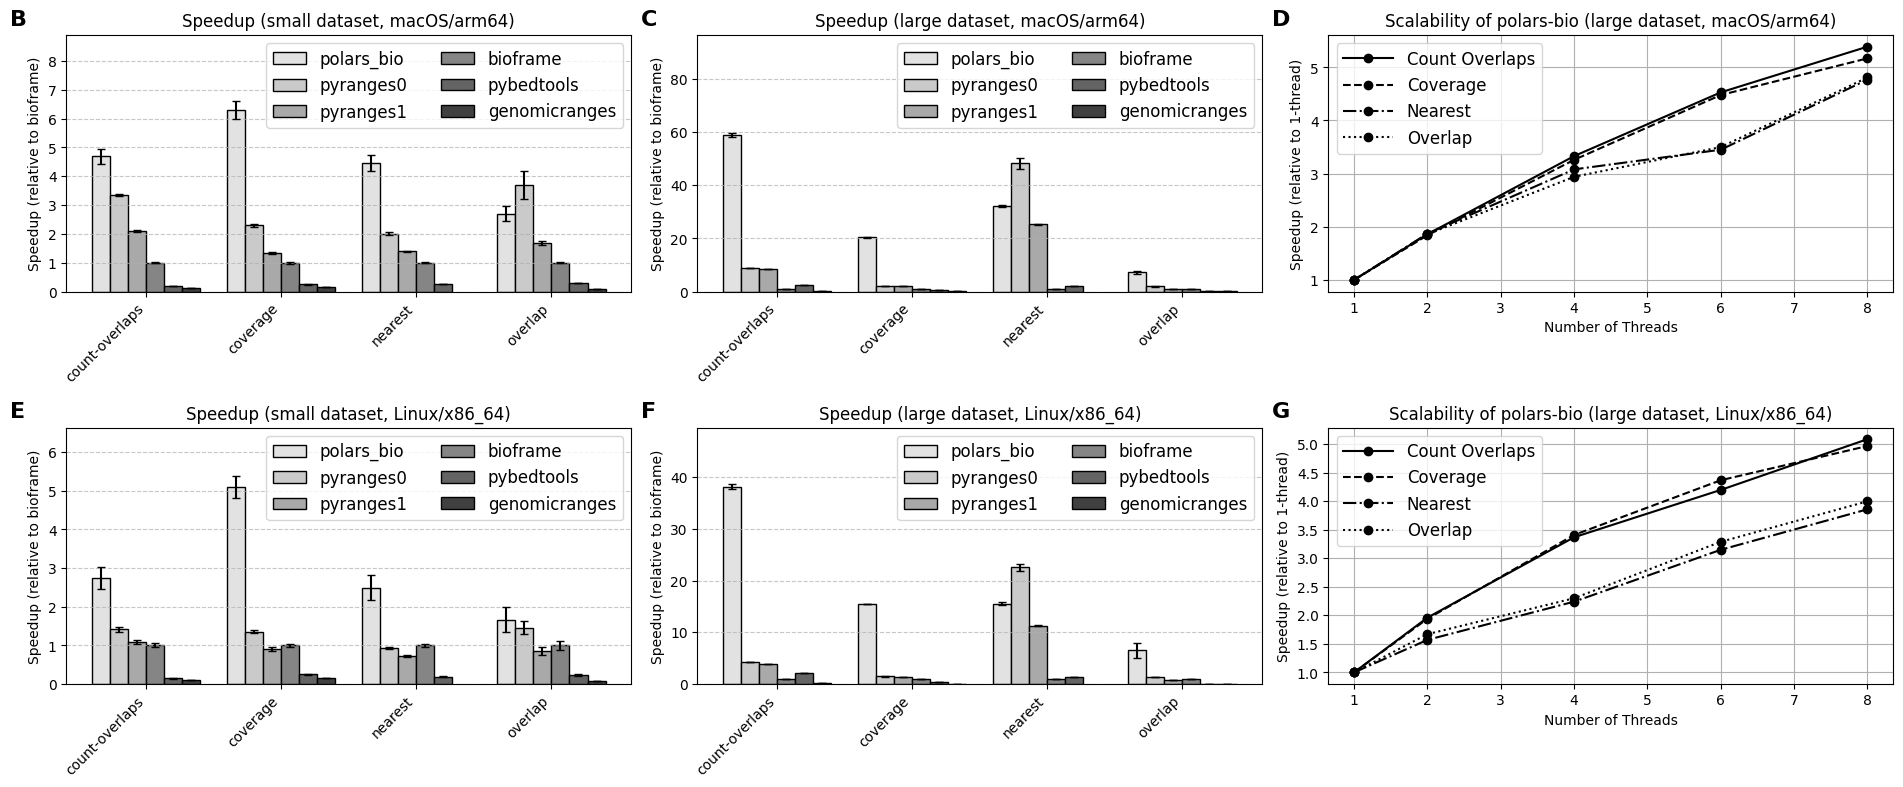

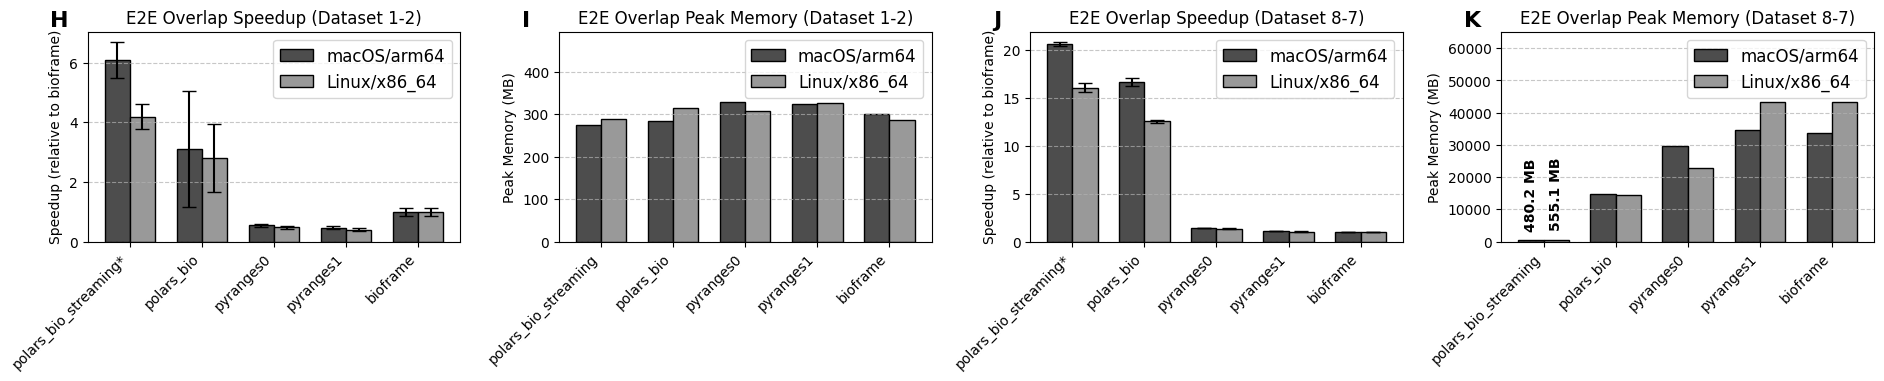

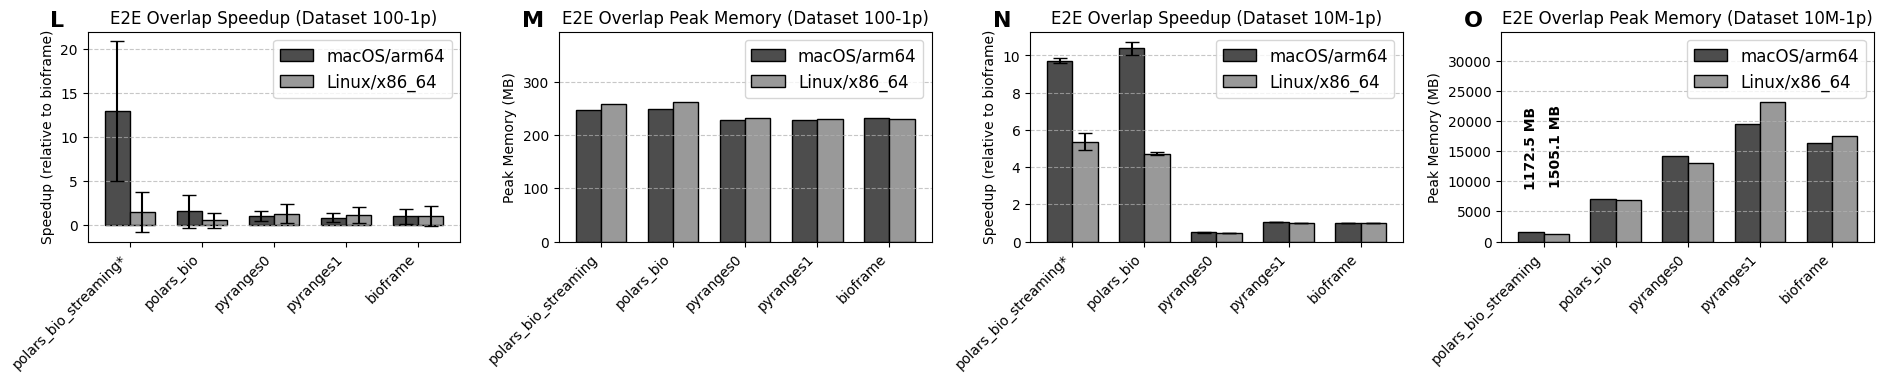

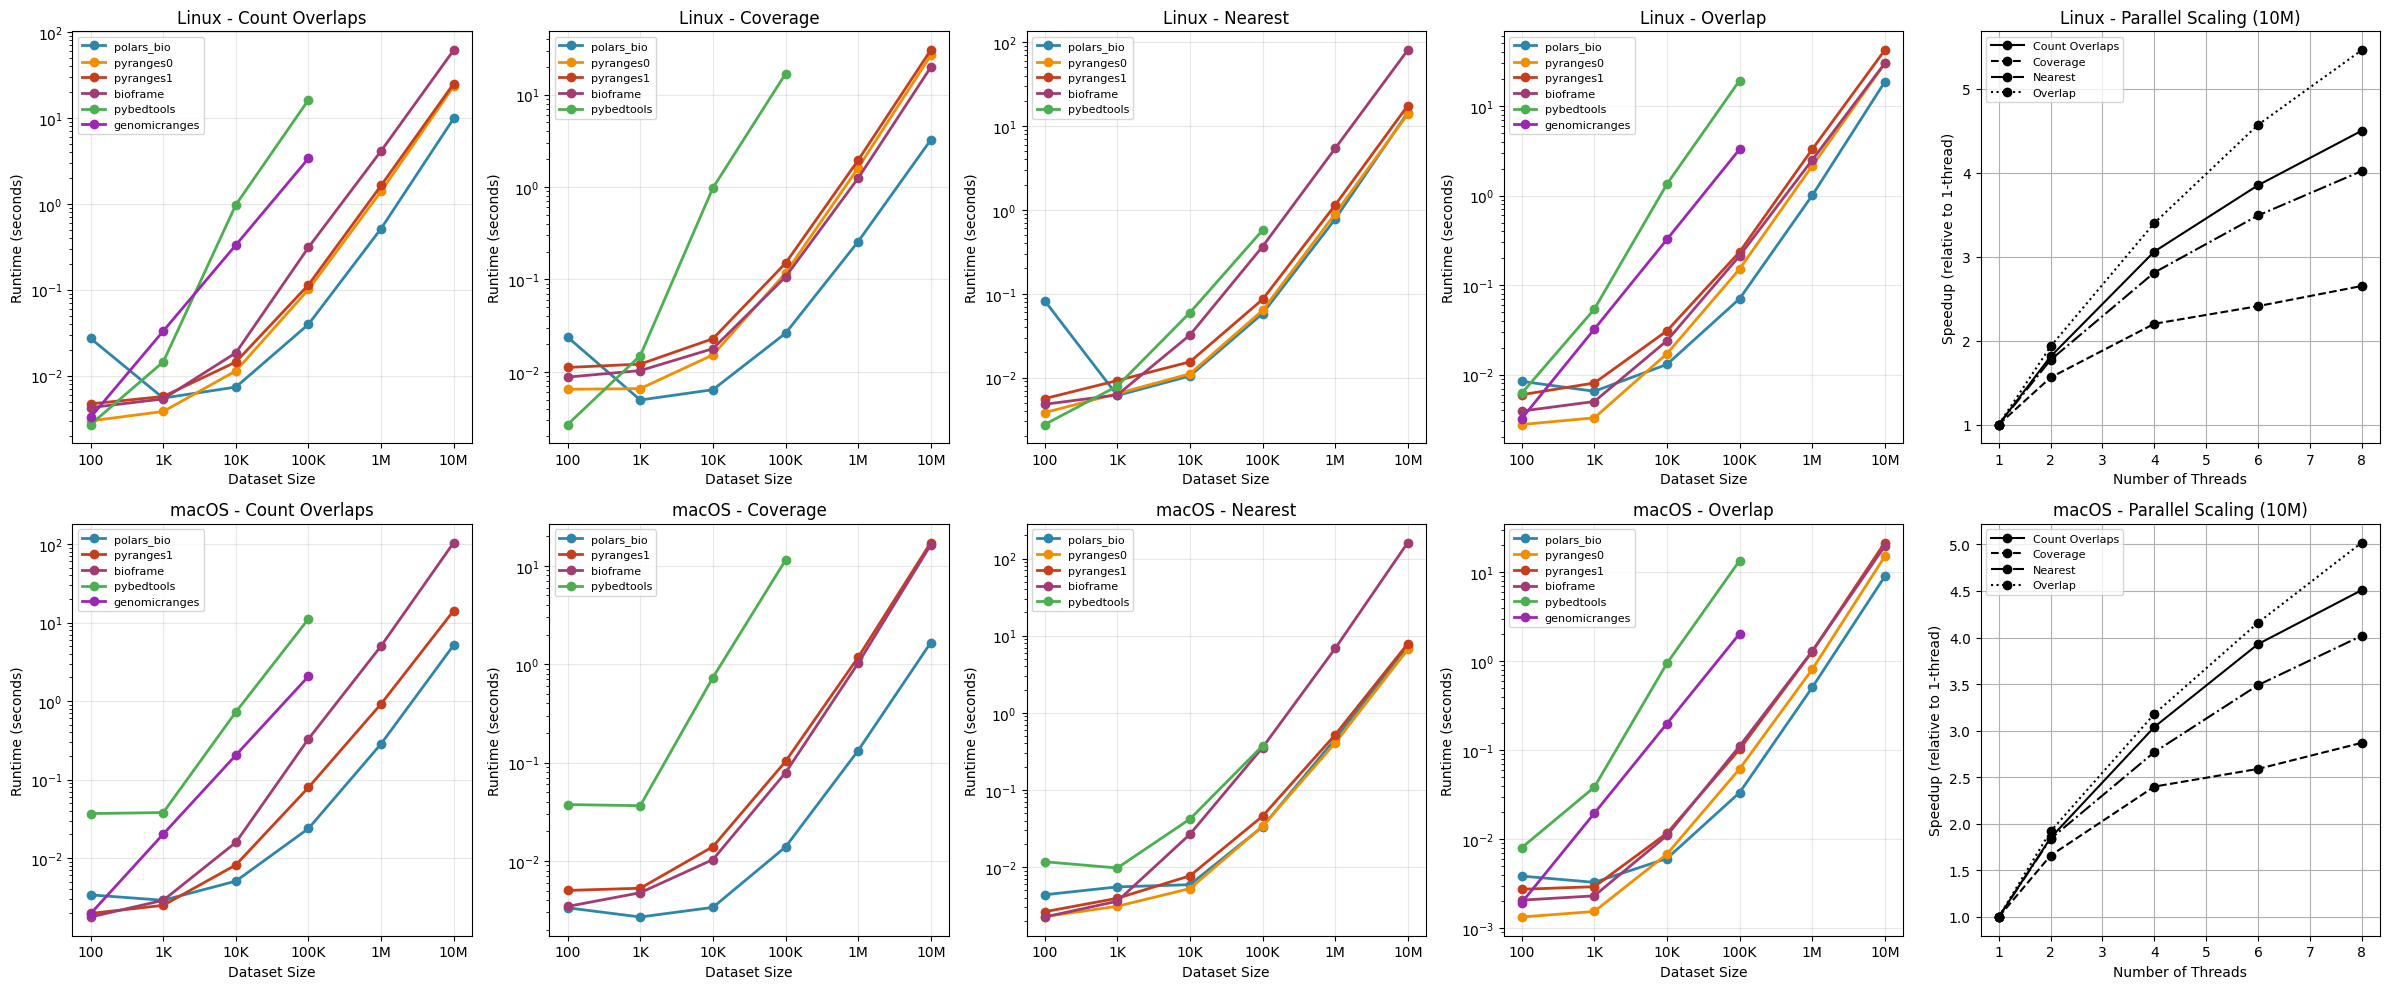

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import svgutils.transform as sg


ORDERED_LIBRARIES = [
    "polars_bio_streaming", "polars_bio", "pyranges0", "pyranges1", 
    "bioframe", "pybedtools", "genomicranges"
]
PERFORMANCE_LIBRARIES = [
    "polars_bio", "pyranges0", "pyranges1", "bioframe", "pybedtools", "genomicranges"
]

def load_data(folder_path, data_type="benchmark", dataset=None, csv_filename=None):
    """
    Unified data loader that handles all data loading use cases.
    
    Parameters:
    - folder_path: path to the base folder containing the data
    - data_type: type of data to load - "benchmark", "e2e", or "synthetic_parallel"
    - dataset: dataset identifier (used for benchmark data, e.g., "1-2", "8-7")
    - csv_filename: specific CSV filename (used for e2e data, e.g., "e2e-overlap-csv/e2e-overlap-csv_1-2.csv")
    
    Returns:
    - Dictionary of dataframes for benchmark/synthetic_parallel data, or single dataframe for e2e data
    """
    if data_type == "benchmark":
        if dataset is None:
            raise ValueError("dataset parameter is required for benchmark data")
        
        operations = ["count-overlaps", "coverage", "nearest", "overlap"]
        data = {}
        for op in operations:
            file_path = os.path.join(folder_path, f"{op}_{dataset}.csv")
            if os.path.exists(file_path):
                try:
                    data[op] = pd.read_csv(file_path)
                    print(f"Loaded: {file_path}")
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
            else:
                print(f"File not found: {file_path}")
        return data
    
    elif data_type == "e2e":
        if csv_filename is None:
            raise ValueError("csv_filename parameter is required for e2e data")
        
        file_path = os.path.join(folder_path, csv_filename)
        if os.path.exists(file_path):
            try:
                data = pd.read_csv(file_path)
                print(f"Loaded: {file_path}")
                return data
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        else:
            print(f"File not found: {file_path}")
        return None
    
    elif data_type == "synthetic_parallel":
        operations = ["count-overlaps", "coverage", "nearest", "overlap"]
        data = {}
        parallel_folder = os.path.join(folder_path, "10000000-8p-parallel")
        
        if not os.path.exists(parallel_folder):
            print(f"Parallel folder not found: {parallel_folder}")
            return data
        
        for op in operations:
            file_path = os.path.join(parallel_folder, f"{op}_10000000-8p.csv")
            
            if os.path.exists(file_path):
                try:
                    df = pd.read_csv(file_path)
                    data[op] = df
                    print(f"Loaded: {file_path}")
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
            else:
                print(f"File not found: {file_path}")
        
        return data
    
    else:
        raise ValueError(f"Unknown data_type: {data_type}. Must be 'benchmark', 'e2e', or 'synthetic_parallel'")


def process_e2e_data(df):
    df = df.copy()
    df['Speedup'] = df['Speedup'].str.rstrip('x').astype(float)
    return df

def reorder_df(df, ordered_libs):
    df['Library'] = pd.Categorical(df['Library'], categories=ordered_libs, ordered=True)
    return df.sort_values('Library')

def extract_threads(library_name):
    if library_name == "polars_bio":
        return 1
    parts = library_name.split("-")
    if len(parts) > 1:
        try:
            return int(parts[1])
        except ValueError:
            return None
    return None

def compute_speedup_with_error(data):
    operations = ["count-overlaps", "coverage", "nearest", "overlap"]
    speedup_data = {'Library': [], 'Operation': [], 'Speedup': [], 'Error': []}
    for op in operations:
        if op in data:
            df = data[op]
            bioframe_row = df[df['Library'] == 'bioframe']
            if bioframe_row.empty:
                continue
            mean_bioframe = bioframe_row['Mean (s)'].values[0]
            std_bioframe = (bioframe_row['Max (s)'].values[0] - bioframe_row['Min (s)'].values[0]) / 2
            for lib in PERFORMANCE_LIBRARIES:
                tool_row = df[df['Library'] == lib]
                if tool_row.empty:
                    speedup_data['Library'].append(lib)
                    speedup_data['Operation'].append(op)
                    speedup_data['Speedup'].append(None)
                    speedup_data['Error'].append(None)
                else:
                    mean_tool = tool_row['Mean (s)'].values[0]
                    std_tool = (tool_row['Max (s)'].values[0] - tool_row['Min (s)'].values[0]) / 2
                    speedup = mean_bioframe / mean_tool
                    speedup_error = speedup * np.sqrt(
                        (std_bioframe / mean_bioframe) ** 2 + (std_tool / mean_tool) ** 2
                    )
                    speedup_data['Library'].append(lib)
                    speedup_data['Operation'].append(op)
                    speedup_data['Speedup'].append(speedup)
                    speedup_data['Error'].append(speedup_error)
    df_speedup = pd.DataFrame(speedup_data)
    df_speedup['Library'] = pd.Categorical(df_speedup['Library'], categories=PERFORMANCE_LIBRARIES, ordered=True)
    return df_speedup.sort_values(['Operation', 'Library'])

def plot_speedup(ax, data, dataset, operating_system):
    speedup_df = compute_speedup_with_error(data)
    operations = ["count-overlaps", "coverage", "nearest", "overlap"]
    pivot_speedup = speedup_df.pivot(index="Operation", columns="Library", values="Speedup").reindex(operations)
    pivot_error = speedup_df.pivot(index="Operation", columns="Library", values="Error").reindex(operations)
    
    x = np.arange(len(operations))
    n_tools = len(PERFORMANCE_LIBRARIES)
    width = 0.8 / n_tools 
    
    colors = [plt.cm.Greys(0.2 + 0.6 * i/(n_tools-1)) for i in range(n_tools)]
    
    for i, tool in enumerate(PERFORMANCE_LIBRARIES):
        speedups = pivot_speedup[tool]
        errors = pivot_error[tool]
        offset = (i - n_tools/2) * width + width/2
        ax.bar(x + offset, speedups, width, yerr=errors, capsize=5,
               label=tool, color=colors[i], edgecolor="black",
               error_kw={'elinewidth': 1.5, 'capsize': 3})
    
    ax.set_xticks(x)
    ax.set_xticklabels(operations, rotation=45, ha="right")
    ax.set_xlabel("")
    ax.set_ylabel("Speedup (relative to bioframe)")
    ax.set_title(f"Speedup ({dataset} dataset, {operating_system})")
    ax.legend(loc="upper right", title="", fontsize=12, ncol=2)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    
    max_val = pivot_speedup.max().max()
    max_val_nearest = pivot_speedup.loc["nearest"].max()
    ax.set_ylim(0, max(max_val*1.3, max_val_nearest * 2))


def preprocess_synthetic_data(data):
    """
    Transform synthetic parallel data to match real data format.
    Converts single DataFrames with multiple polars_bio entries to format 
    compatible with real parallel data processing.
    
    Parameters:
    - data: dictionary of dataframes from synthetic parallel scaling
    
    Returns:
    - Dictionary of dataframes in real data format
    """
    processed_data = {}
    
    for op, df in data.items():
        if df is None or df.empty:
            continue
            
        # Create new dataframe with polars_bio libraries for different thread counts
        new_rows = []
        
        for _, row in df.iterrows():
            lib = row['Library']
            if lib.startswith('polars_bio'):
                # Create a new row with the library name formatted like real data
                new_row = row.copy()
                if lib == 'polars_bio':
                    new_row['Library'] = 'polars_bio'  # 1 thread
                else:
                    # Keep the format like 'polars_bio-2', 'polars_bio-4', etc.
                    new_row['Library'] = lib
                new_rows.append(new_row)
        
        if new_rows:
            processed_data[op] = pd.DataFrame(new_rows)
    
    return processed_data


def plot_unified_scaling(ax, data=None, operating_system="Linux", metric="speedup", plot_type="parallel"):
    """
    Unified function to plot parallel scaling data - handles both real and synthetic parallel scaling.
    
    Parameters:
    - ax: matplotlib axes object
    - data: dictionary of dataframes (for both real and synthetic parallel scaling)
    - operating_system: name of the operating system for the title
    - metric: "speedup" or "runtime" for real data
    - plot_type: "parallel" for real data thread scaling, "synthetic" for synthetic data thread scaling
    """
    if data is None:
        ax.text(0.5, 0.5, "No parallel data available", 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"Parallel Scaling - {operating_system}")
        return
    
    # Preprocess synthetic data to match real data format for unified processing
    if plot_type == "synthetic":
        data = preprocess_synthetic_data(data)
        
    operations = ["count-overlaps", "coverage", "nearest", "overlap"]
    line_styles = ['-', '--', '-.', ':']
    
    # Unified processing for both real and synthetic data
    for idx, op in enumerate(operations):
        if op in data:
            df = data[op].copy()
            df = df[df['Library'] != "polars_bio_streaming"]
            df['threads'] = df['Library'].apply(extract_threads)
            df = df.sort_values('threads')
            
            if metric.lower() == "speedup":
                df['Speedup'] = df['Speedup'].str.rstrip('x').astype(float)
                y = df['Speedup']
            else:
                y = df["Mean (s)"]
                
            ax.plot(df['threads'], y, linestyle=line_styles[idx % len(line_styles)],
                    marker='o', color='black', label=op.replace('-', ' ').title())
    
    # Set labels and formatting - unified logic with minor differences
    y_label = "Speedup (relative to 1-thread)" if metric.lower() == "speedup" else "Mean Runtime (s)"
    
    # Title and legend size are the only differences between plot types
    title = f"Scalability of polars-bio (large dataset, {operating_system})" if plot_type == "parallel" else f"{operating_system} - Parallel Scaling (10M)"
    legend_fontsize = 12 if plot_type == "parallel" else 8
    
    ax.set_xlabel("Number of Threads")
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(np.arange(1, 9, 1))
    ax.legend(loc="upper left", ncol=1, fontsize=legend_fontsize, handlelength=3)
    ax.grid(True)
        

def compute_e2e_speedup_with_error(df):
    speedup_data = {'Library': [], 'Speedup': [], 'Error': []}
    baseline_row = df[df['Library'] == 'bioframe']
    if baseline_row.empty:
        return pd.DataFrame(speedup_data)
    mean_bioframe = baseline_row['Mean (s)'].values[0]
    std_bioframe = (baseline_row['Max (s)'].values[0] - baseline_row['Min (s)'].values[0]) / 2
    for idx, row in df.iterrows():
        lib = row['Library']
        
        if pd.isna(row['Speedup']):
            speedup_data['Library'].append(lib)
            speedup_data['Speedup'].append(None)
            speedup_data['Error'].append(None)
        else:
            mean_tool = row['Mean (s)']
            std_tool = (row['Max (s)'] - row['Min (s)']) / 2
            # Ensure speedup is a float, handling both string and float types
            speedup_raw = row['Speedup']
            if isinstance(speedup_raw, str):
                speedup = float(speedup_raw.rstrip('x'))
            else:
                speedup = float(speedup_raw)
            error = speedup * np.sqrt((std_bioframe/mean_bioframe)**2 + (std_tool/mean_tool)**2)
            speedup_data['Library'].append(lib)
            speedup_data['Speedup'].append(speedup)
            speedup_data['Error'].append(error)
    return pd.DataFrame(speedup_data)

def plot_e2e_comparison(ax, macos_df, linux_df, metric, title, ylabel):
    if metric.lower() == "speedup":
        macos_speedup = compute_e2e_speedup_with_error(macos_df)
        linux_speedup = compute_e2e_speedup_with_error(linux_df)
        merged = pd.merge(macos_speedup, linux_speedup, on="Library", how="outer", suffixes=("_macos", "_linux"))
        merged = reorder_df(merged, ORDERED_LIBRARIES)
        x = np.arange(len(merged["Library"]))
        width = 0.35
        macos_color = "0.3"
        linux_color = "0.6"
        ax.bar(x - width/2, merged["Speedup_macos"].fillna(0), width,
               yerr=merged["Error_macos"].fillna(0), capsize=5,
               label="macOS/arm64", color=macos_color, edgecolor='black')
        ax.bar(x + width/2, merged["Speedup_linux"].fillna(0), width,
               yerr=merged["Error_linux"].fillna(0), capsize=5,
               label="Linux/x86_64", color=linux_color, edgecolor='black')
    else:
        merged = pd.merge(macos_df, linux_df, on="Library", how="outer", suffixes=("_macos", "_linux"))
        merged = reorder_df(merged, ORDERED_LIBRARIES)
        x = np.arange(len(merged["Library"]))
        width = 0.35
        macos_color = "0.3"
        linux_color = "0.6"
        ax.bar(x - width/2, merged[metric + "_macos"].fillna(0), width,
               label="macOS/arm64", color=macos_color, edgecolor='black')
        ax.bar(x + width/2, merged[metric + "_linux"].fillna(0), width,
               label="Linux/x86_64", color=linux_color, edgecolor='black')
    ax.set_xticks(x)
    #ax.set_xticklabels(merged["Library"], rotation=45, ha="right")
    if metric.lower() == "speedup":
        tick_labels = [lib + "*" if lib == "polars_bio_streaming" else lib for lib in merged["Library"]]
    else:
        tick_labels = merged["Library"]
    ax.set_xticklabels(tick_labels, rotation=45, ha="right")

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle="--", alpha=0.7)
    col_macos = metric + "_macos"
    col_linux = metric + "_linux"
    if metric.lower().startswith("peak memory"): # scale y-axis for peak memory
        max_val = merged[[col_macos, col_linux]].max().max()
        ax.set_ylim(0, max_val * 1.5)
        if title.endswith("Dataset 8-7)") or title.endswith("Dataset 10M-1p)"):  # additional annotation for dataset 8-7 and 10M-1p
            idx = merged.index[merged["Library"] == "polars_bio_streaming"]
            if not idx.empty:
                pos = np.where(merged["Library"] == "polars_bio_streaming")[0][0]
                x_pos = x[pos]
                y_val_macos = merged.loc[merged.index[pos], col_macos]
                y_val_linux = merged.loc[merged.index[pos], col_linux]
                if pd.notna(y_val_macos):
                    offset = y_val_macos * 5
                    ax.text(x_pos - width/2, y_val_linux + offset, f"{y_val_linux:.1f} MB",
                            transform=ax.transData,
                            ha="center", va="bottom", fontsize=10, fontweight="bold", color="black",
                            rotation=90)
                    ax.text(x_pos + width/2, y_val_macos + offset, f"{y_val_macos:.1f} MB",
                            transform=ax.transData,
                            ha="center", va="bottom", fontsize=10, fontweight="bold", color="black",
                            rotation=90)

def plot_synthetic_scaling(ax, base_folder_path, operation="count-overlaps"):
    """Plot performance scaling across synthetic dataset sizes (100-1p to 10M-1p)"""
    dataset_sizes = ["100-1p", "1000-1p", "10000-1p", "100000-1p", "1000000-1p", "10000000-1p"]
    dataset_labels = ["100", "1K", "10K", "100K", "1M", "10M"]
    
    # Colors for different libraries
    library_colors = {
        'polars_bio': '#2E86AB',
        'bioframe': '#A23B72', 
        'pyranges0': '#F18F01',
        'pyranges1': '#C73E1D',
        'pybedtools': '#4CAF50',
        'genomicranges': '#9C27B0'
    }
    
    for lib in PERFORMANCE_LIBRARIES:
        times = []
        sizes = []
        
        for size, label in zip(dataset_sizes, dataset_labels):
            folder_path = os.path.join(base_folder_path, size)
            file_path = os.path.join(folder_path, f"{operation}_{size}.csv")
            
            if os.path.exists(file_path):
                try:
                    df = pd.read_csv(file_path)
                    lib_row = df[df['Library'] == lib]
                    if not lib_row.empty:
                        mean_time = lib_row['Mean (s)'].values[0]
                        times.append(mean_time)
                        sizes.append(label)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
        
        if times:
            ax.plot(sizes, times, marker='o', linewidth=2, markersize=6, 
                   label=lib, color=library_colors.get(lib, 'gray'))
    
    ax.set_xlabel("Dataset Size")
    ax.set_ylabel("Runtime (seconds)")
    ax.set_title(f"Synthetic Dataset Scaling - {operation.replace('-', ' ').title()}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')


paper_folder_path = "../results/paper"
figures_path = "figures/"

# Create figures directory if it doesn't exist
os.makedirs(figures_path, exist_ok=True)

apple_m3_max_folder_path = os.path.join(paper_folder_path, "apple-m3-max")
gcp_linux_folder_path = os.path.join(paper_folder_path, "gcp-linux")
apple_m3_max_8_7_folder_path = os.path.join(apple_m3_max_folder_path, "8-7")
apple_m3_max_8_7_parallel_folder_path = os.path.join(apple_m3_max_folder_path, "8-7-8p-parallel")
apple_m3_max_1_2_folder_path = os.path.join(apple_m3_max_folder_path, "1-2")
apple_m3_max_7_8_folder_path = os.path.join(apple_m3_max_folder_path, "7-8")
gcp_linux_1_2_folder_path = os.path.join(gcp_linux_folder_path, "1-2")
gcp_linux_7_8_folder_path = os.path.join(gcp_linux_folder_path, "7-8")
gcp_linux_8_7_folder_path = os.path.join(gcp_linux_folder_path, "8-7")
gcp_linux_8_7_parallel_folder_path = os.path.join(gcp_linux_folder_path, "8-7-8p-parallel")

macos_1_2_data = load_data(apple_m3_max_1_2_folder_path, "benchmark", "1-2")
macos_7_8_data = load_data(apple_m3_max_7_8_folder_path, "benchmark", "7-8")
macos_8_7_data = load_data(apple_m3_max_8_7_folder_path, "benchmark", "8-7")
linux_1_2_data = load_data(gcp_linux_1_2_folder_path, "benchmark", "1-2")
linux_7_8_data = load_data(gcp_linux_7_8_folder_path, "benchmark", "7-8")
linux_8_7_data = load_data(gcp_linux_8_7_folder_path, "benchmark", "8-7")
macos_8_7_parallel_data = load_data(apple_m3_max_8_7_parallel_folder_path, "benchmark", "8-7-8p")
linux_8_7_parallel_data = load_data(gcp_linux_8_7_parallel_folder_path, "benchmark", "8-7-8p")

macos_e2e_1_2 = load_data(apple_m3_max_folder_path, "e2e", csv_filename="e2e-overlap-csv/e2e-overlap-csv_1-2.csv")
linux_e2e_1_2 = load_data(gcp_linux_folder_path, "e2e", csv_filename="e2e-overlap-csv/e2e-overlap-csv_1-2.csv")
macos_e2e_8_7 = load_data(apple_m3_max_folder_path, "e2e", csv_filename="e2e-overlap-csv/e2e-overlap-csv_8-7.csv")
linux_e2e_8_7 = load_data(gcp_linux_folder_path, "e2e", csv_filename="e2e-overlap-csv/e2e-overlap-csv_8-7.csv")

# Load E2E data for synthetic datasets
macos_e2e_100_1p = load_data(apple_m3_max_folder_path, "e2e", csv_filename="e2e-overlap-csv/e2e-overlap-csv_100-1p.csv")
linux_e2e_100_1p = load_data(gcp_linux_folder_path, "e2e", csv_filename="e2e-overlap-csv/e2e-overlap-csv_100-1p.csv")
macos_e2e_10m_1p = load_data(apple_m3_max_folder_path, "e2e", csv_filename="e2e-overlap-csv/e2e-overlap-csv_10000000-1p.csv")
linux_e2e_10m_1p = load_data(gcp_linux_folder_path, "e2e", csv_filename="e2e-overlap-csv/e2e-overlap-csv_10000000-1p.csv")

# Process synthetic E2E data
if macos_e2e_100_1p is not None:
    macos_e2e_100_1p = process_e2e_data(macos_e2e_100_1p)
if linux_e2e_100_1p is not None:
    linux_e2e_100_1p = process_e2e_data(linux_e2e_100_1p)
if macos_e2e_10m_1p is not None:
    macos_e2e_10m_1p = process_e2e_data(macos_e2e_10m_1p)
if linux_e2e_10m_1p is not None:
    linux_e2e_10m_1p = process_e2e_data(linux_e2e_10m_1p)

performance_plots = [
    {"func": plot_speedup, "data": macos_1_2_data, "dataset": "small", "os": "macOS/arm64"},
    {"func": plot_speedup, "data": macos_8_7_data, "dataset": "large", "os": "macOS/arm64"},
    {"func": plot_unified_scaling, "data": macos_8_7_parallel_data, "dataset": "8-7", "os": "macOS/arm64", "metric": "speedup", "plot_type": "parallel"},
    {"func": plot_speedup, "data": linux_1_2_data, "dataset": "small", "os": "Linux/x86_64"},
    {"func": plot_speedup, "data": linux_8_7_data, "dataset": "large", "os": "Linux/x86_64"},
    {"func": plot_unified_scaling, "data": linux_8_7_parallel_data, "dataset": "8-7", "os": "Linux/x86_64", "metric": "speedup", "plot_type": "parallel"}
]

fig_perf, axs_perf = plt.subplots(2, 3, figsize=(19, 8))
axs_perf = axs_perf.flatten()
panel_labels_perf = ["B", "C", "D", "E", "F", "G"]

for ax, plot_def, label in zip(axs_perf, performance_plots, panel_labels_perf):
    if plot_def["func"] == plot_speedup:
        plot_speedup(ax, plot_def["data"], plot_def["dataset"], plot_def["os"])
    elif plot_def["func"] == plot_unified_scaling:
        metric = plot_def.get("metric", "speedup")
        plot_type = plot_def.get("plot_type", "parallel")
        plot_unified_scaling(ax, data=plot_def["data"], operating_system=plot_def["os"], metric=metric, plot_type=plot_type)
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.savefig(os.path.join(figures_path, "performance.svg"), format="svg")
print("Generated performance.svg")

e2e_plots = [
    {"title": "E2E Overlap Speedup (Dataset 1-2)", "macos": macos_e2e_1_2, "linux": linux_e2e_1_2,
     "metric": "Speedup", "ylabel": "Speedup (relative to bioframe)"},
    {"title": "E2E Overlap Peak Memory (Dataset 1-2)", "macos": macos_e2e_1_2, "linux": linux_e2e_1_2,
     "metric": "Peak memory (MB)", "ylabel": "Peak Memory (MB)"},
    {"title": "E2E Overlap Speedup (Dataset 8-7)", "macos": macos_e2e_8_7, "linux": linux_e2e_8_7,
     "metric": "Speedup", "ylabel": "Speedup (relative to bioframe)"},
    {"title": "E2E Overlap Peak Memory (Dataset 8-7)", "macos": macos_e2e_8_7, "linux": linux_e2e_8_7,
     "metric": "Peak memory (MB)", "ylabel": "Peak Memory (MB)"}
]

fig_e2e, axs_e2e = plt.subplots(1, 4, figsize=(19, 4))
panel_labels_e2e = ["H", "I", "J", "K"]

for ax, plot_def, label in zip(axs_e2e, e2e_plots, panel_labels_e2e):
    if plot_def["macos"] is not None and plot_def["linux"] is not None:
        plot_e2e_comparison(ax, plot_def["macos"], plot_def["linux"],
                            plot_def["metric"], plot_def["title"], plot_def["ylabel"])
    else:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_title(plot_def["title"])
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.savefig(os.path.join(figures_path, "e2e_performance.svg"), format="svg")
print("Generated e2e_performance.svg")

# E2E synthetic dataset plots (L-O panels)
e2e_synthetic_plots = [
    {"title": "E2E Overlap Speedup (Dataset 100-1p)", "macos": macos_e2e_100_1p, "linux": linux_e2e_100_1p,
     "metric": "Speedup", "ylabel": "Speedup (relative to bioframe)"},
    {"title": "E2E Overlap Peak Memory (Dataset 100-1p)", "macos": macos_e2e_100_1p, "linux": linux_e2e_100_1p,
     "metric": "Peak memory (MB)", "ylabel": "Peak Memory (MB)"},
    {"title": "E2E Overlap Speedup (Dataset 10M-1p)", "macos": macos_e2e_10m_1p, "linux": linux_e2e_10m_1p,
     "metric": "Speedup", "ylabel": "Speedup (relative to bioframe)"},
    {"title": "E2E Overlap Peak Memory (Dataset 10M-1p)", "macos": macos_e2e_10m_1p, "linux": linux_e2e_10m_1p,
     "metric": "Peak memory (MB)", "ylabel": "Peak Memory (MB)"}
]

fig_e2e_synthetic, axs_e2e_synthetic = plt.subplots(1, 4, figsize=(19, 4))
panel_labels_e2e_synthetic = ["L", "M", "N", "O"]

for ax, plot_def, label in zip(axs_e2e_synthetic, e2e_synthetic_plots, panel_labels_e2e_synthetic):
    if plot_def["macos"] is not None and plot_def["linux"] is not None:
        plot_e2e_comparison(ax, plot_def["macos"], plot_def["linux"],
                            plot_def["metric"], plot_def["title"], plot_def["ylabel"])
    else:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_title(plot_def["title"])
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.savefig(os.path.join(figures_path, "e2e_synthetic_performance.svg"), format="svg")
print("Generated e2e_synthetic_performance.svg")

# New synthetic dataset scaling plots
print("\nGenerating synthetic dataset scaling plots...")

# Create synthetic scaling plots for all 4 operations
operations = ["count-overlaps", "coverage", "nearest", "overlap"]

# Load synthetic parallel data for both platforms
print("Loading synthetic parallel data...")
gcp_linux_synthetic_parallel_data = load_data(gcp_linux_folder_path, "synthetic_parallel")
apple_m3_max_synthetic_parallel_data = load_data(apple_m3_max_folder_path, "synthetic_parallel")

# 3. Combined grid: 5x2 layout - Linux plots on top row, macOS plots on bottom row
fig_combined_scaling, axs_combined = plt.subplots(2, 5, figsize=(24, 10))

# Top row: Linux plots (4 dataset scaling + 1 parallel scaling)
for i, operation in enumerate(operations):
    plot_synthetic_scaling(axs_combined[0, i], gcp_linux_folder_path, operation)
    axs_combined[0, i].set_title(f"Linux - {operation.replace('-', ' ').title()}")

# Linux parallel scaling plot (top row, 5th column) - using unified function for synthetic parallel scaling
plot_unified_scaling(axs_combined[0, 4], data=gcp_linux_synthetic_parallel_data, operating_system="Linux", plot_type="synthetic")

# Bottom row: macOS plots (4 dataset scaling + 1 parallel scaling)
for i, operation in enumerate(operations):
    plot_synthetic_scaling(axs_combined[1, i], apple_m3_max_folder_path, operation)
    axs_combined[1, i].set_title(f"macOS - {operation.replace('-', ' ').title()}")

# macOS parallel scaling plot (bottom row, 5th column) - using unified function for synthetic parallel scaling
plot_unified_scaling(axs_combined[1, 4], data=apple_m3_max_synthetic_parallel_data, operating_system="macOS", plot_type="synthetic")

plt.tight_layout()
plt.savefig(os.path.join(figures_path, "combined_scaling.svg"), format="svg")
print("Generated combined_scaling.svg")




plt.tight_layout()


import svgutils.transform as sg
from svgutils.transform import TextElement

# Check if required SVG files exist before loading
svg_files = [
    "polars-bio-paper-v2.svg",
    "polars-bio-paper-flow-diagram-v2.svg"
]

missing_files = []
for svg_file in svg_files:
    if not os.path.exists(os.path.join(figures_path, svg_file)):
        missing_files.append(svg_file)

if missing_files:
    print(f"Warning: Missing SVG files: {missing_files}")
    print("Creating placeholder combined.svg with available plots only...")
    
    # Create a comprehensive combined figure with generated plots
    fig_simple = sg.SVGFigure("1400", "2000")
    plot2 = sg.fromfile(os.path.join(figures_path, "performance.svg")).getroot()
    plot3 = sg.fromfile(os.path.join(figures_path, "e2e_performance.svg")).getroot()
    plot3_synthetic = sg.fromfile(os.path.join(figures_path, "e2e_synthetic_performance.svg")).getroot()
    plot_scaling = sg.fromfile(os.path.join(figures_path, "combined_scaling.svg")).getroot()
    
    plot2.moveto(0, 0)
    plot3.moveto(0, 400)
    plot3_synthetic.moveto(0, 800)
    plot_scaling.moveto(0, 1200)
    
    fig_simple.append([plot2, plot3, plot3_synthetic, plot_scaling])
    fig_simple.save(os.path.join(figures_path, "combined.svg"))
    print("Created comprehensive combined.svg with scaling and synthetic E2E plots")
else:
    # Enhanced version with all plots when SVG files are available
    plot1 = sg.fromfile(os.path.join(figures_path, "polars-bio-paper-v2.svg")).getroot()
    plot2 = sg.fromfile(os.path.join(figures_path, "performance.svg")).getroot()
    plot3 = sg.fromfile(os.path.join(figures_path, "e2e_performance.svg")).getroot()
    plot3_synthetic = sg.fromfile(os.path.join(figures_path, "e2e_synthetic_performance.svg")).getroot()
    plot4 = sg.fromfile(os.path.join(figures_path, "polars-bio-paper-flow-diagram-v2.svg")).getroot()
    plot_scaling = sg.fromfile(os.path.join(figures_path, "combined_scaling.svg")).getroot()
    
    text_A = TextElement(10, 30, "A", size="17px", weight="bold")
    text_L = TextElement(10, 30, "L", size="17px", weight="bold")
    text_M = TextElement(10, 30, "M", size="17px", weight="bold")

    new_plot1 = sg.GroupElement([plot1, text_A])
    new_plot4 = sg.GroupElement([plot4, text_L])
    new_plot_scaling = sg.GroupElement([plot_scaling, text_M])

    new_plot1.moveto(0, 0)
    plot2.moveto(0, 400)
    plot3.moveto(0, 970)
    plot3_synthetic.moveto(0, 1370)
    new_plot4.moveto(0, 1770)
    new_plot_scaling.moveto(0, 2170)
    
    fig_combined = sg.SVGFigure("1400", "2700")
    fig_combined.root.set("viewBox", "0 0 1400 2600")
    fig_combined.append([new_plot1, plot2, plot3, plot3_synthetic, new_plot4, new_plot_scaling])
    fig_combined.save(os.path.join(figures_path, "combined.svg"))
    print("Created full combined.svg with all plots including synthetic E2E plots")
